# Indian Buffet Processes

## Notes by Hugh Perkins, 2016

These notes adapted from:

- ["The Indian Buffet Process: An Introduction and Review"](http://jmlr.org/papers/volume12/griffiths11a/griffiths11a.pdf), Griffiths, Ghahramani, 2011
- ["Introduction to the Dirichlet Distribution and Related Processes"](http://mayagupta.org/publications/FrigyikKapilaGuptaIntroToDirichlet.pdf), Frigyik, Kapila, Gupta
- ["Advanced Data Analysis from an Elementary Point of View"](http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/), Cosma Rohilla Shalizi, chapter 19, "Mixture Models"
- ["Mixture Models and the EM Algorithm"](http://mlg.eng.cam.ac.uk/tutorials/06/cb.pdf), slide presentation by Bishop 2006

The tutorial by Griffiths and Gahramani above was my primary resouce.  Then, in order to understand it, I needed to reach out to the other resources above :-)

Generally speaking, these notes assume that you are reading the appropriate tutorial/paper/slides in parallel with these notes.  These notes are made:

- to help me work through the maths
- to help me clarify in my head things that I had to stop and stare at for a while

Let's start by revising multinomial and dirichlet distributions.

# Multinomial and Dirichlet Distributions

These notes adapted from "Introduction to the Dirichlet Distribution and Related Processes", Frigyik, Kapila, Gupta

## Multinomial distribution

The multinomial distribution is parametrized by an integer $n$ and a pmf $q = [q_1, q_2, \dots,q_k]$, and can be thought of as follows: if we have $n$ independent events, and for each event, the probability of outcome $i$ is $q_i$, then the multinomial distribution specifies the probability that outcome $i$ occurs $x_i$ times for $i=1,2,\dots,k$.  For example, the multinomial distribution can model the probability of an $n$-sample empirical histogram, if each sample is drawn iid from $q$.  If $X \sim \mathrm{Multinomial}_k(n,q)$, then its probability mass function is given by:

$$P(X=\{x_1,x_2,\dots,x_k \} \mid n,Q = \{q_1, q_2, ..., q_k\} ) = \frac{n!}{x_1!x_2!\dots x_k!}\prod_{i=1}^k q_i^{x_i}$$

When $k=2$, the multinomial distribution reduces to the binomial distribution.

Example with some actual concrete numbers plugged in:

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import math

n = 3
k = 3

# some possible distributions of x:
Xs = [
    [3, 0, 0],
    [1, 1, 1],
    [2, 1, 0]
]

# and here's our Q, ie, in this case, uniform distribution of possible values:
Q = [1/k] * k

for X in Xs:
    numerator = math.factorial(n)
    denominator = 1
    prod_qi_xi = 1
    for i in range(k):
        denominator *= math.factorial(X[i])
        prod_qi_xi *= math.pow(Q[i], X[i])
    p = numerator * prod_qi_xi / denominator
    odds = 1 / p
    print('X', X, 'p', p, 'odds 1 in %s' % (int(odds * 10000) / 10000))


X [3, 0, 0] p 0.03703703703703703 odds 1 in 27.0
X [1, 1, 1] p 0.2222222222222222 odds 1 in 4.5
X [2, 1, 0] p 0.1111111111111111 odds 1 in 9.0


There are 3 ways of arranging `[3, 0, 0]`, 1 way of arranging `[1, 1, 1]`, and `3 * 2 = 6` ways of arranging `[2, 1, 0]`, so total probability is:

$$1/27 * 3 + 1/4.5 * 1 + 1/9 * 6$$

$$= 1$$ (As required)

## Dirichlet distribution

A Dirichlet distribution is a distribution over probability mass functions of length $k$, that is over the $k-1$-dimensional probability simplex $\Delta_k$, where:

$$\Delta_k = \left\{ q \in \mathbb{R}^k \mid \sum_{i=1}^k q_i = 1, q_i \ge 0 \ \, \mathrm{ for }\, i=1,2,\dots,k \right\}$$

If $q\sim \mathrm{Dir}(\alpha)$ then:

$$p(q \mid \alpha) = \frac{\Gamma(\alpha_0)}{\prod_{i=1}^k\Gamma(\alpha_i)}\prod_{i=1}^k q_i^{\alpha_i-1}$$

Gamma function is generalization of the factorial function: for $s \gt 0$:

$$\Gamma(s + 1) = s\Gamma(s)$$

For positive integers $n$, $\Gamma(n) = (n-1)!$, and $\Gamma(1) = 1$

When $k=2$, the Dirichlet reduces to the Beta distribution:

$$f(x;\alpha,\beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{\alpha-1}(1-x)^{\beta-1}$$

If $X \sim \mathrm{Beta}(a,b)$, then $Q=(X, 1-X) \sim \mathrm{Dir}(\alpha)$, where $\alpha=[a\,b]$

Note that the form of the Dirichlet Distribution is basically identical to the Multinomial Distribution, except:

- normalization is generalized, to handle non-integer $\alpha_i$ values, using Gamma function
- $1$ is subtracted from each $\alpha_i$ value

This will lead to the usage of a Dirichlet distribution as a conjugate prior for the Multinomial distribution, see later.

## Properties of the Dirichlet Distribution

(Just copying these from the tutorial mentioned above, without discussion for now)

Density: $\frac{1}{B(\alpha)} \prod_{j=1}^d q_j^{\alpha_j-1}$

Expectation: $\frac{\alpha_i}{\alpha_0}$

Mode: $\frac{\alpha - 1}{\alpha_0 - k}$

Marginal distribution: $q_i \sim \mathrm{Beta}(\alpha_i, \alpha_0 - \alpha_i)$

Conditional distribution: $(q_{-i} \mid q_i ) \sim (1 - q_i) \, \mathrm{Dir}(\alpha_{-i})$

## Conjugate prior for the multinomial

Let's draw as follows:

$$\mathbf{q} \sim \,\mathrm{Dir}\,(\mathbf{\alpha})$$
$$\mathbf{x} \sim \,\mathrm{Mult}_k\,(n, \mathbf{q}) $$

What is $p(\mathbf{q} \mid \mathbf{x}, \mathbf{\alpha})$?

$$p(\mathbf{q} \mid \mathbf{x} = \gamma \, p(\mathbf{x} \mid \mathbf{q})\,p(\mathbf{q})$$
$$=\gamma\, \mathrm{Mult}_k\,(n, \mathbf{q}) \, \mathrm{Dir}\,(\mathbf{\alpha})$$
$$=\gamma\left( \frac{n!}{x_1!x_2!\dots x_k!} \prod_{i=1}^k q_i^{x_i} \right) \left( \frac{\Gamma(\alpha_1 + \dots + \alpha_k}{\prod_{i=1}^k \Gamma(\alpha_i)} \prod_{i=1}^k q_i^{\alpha_i - 1} \right)$$
$$=\tilde{\gamma}\prod_{i=1}^k q_i^{\alpha_i + x_i - 1}$$
$$=\tilde{\gamma} \, \mathrm{Dir}(\mathbf{\alpha} + \mathbf{x})$$

Hence:
$$(Q \mid X = \mathbf{x}) \sim \mathrm{Dir}(\mathbf{\alpha} + \mathbf{x})$$

# Mixture models

Probably good to revise mixture models too...

These notes are based on [Cosma Shalizi's book](http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/), chapter 19, "Mixture Models", and on the slide presentation ["Mixture Models and the EM Algorithm", Bishop 2006](http://mlg.eng.cam.ac.uk/tutorials/06/cb.pdf)

A mixture model is defined as:

$$p(\mathbf{x} = \sum_{i=1}^k \theta_i f_i(\mathbf{x})$$
where $f_i(\cdot)$ are probability distributions over $\mathbf{x}$, eg they could be Gaussian distributions.

To generate points, we need to:

- draw a class, $c_j$ for $j$ in $1,2,\dots n$
- draw a point, $\mathbf{x}_j$ for $j$ in $1,2,\dots,n$

Let's try this, for gaussian distributions, with $d=2$ features, and $k=3$ clusters:

theta [ 0.04313748  0.19931057  0.75755195]


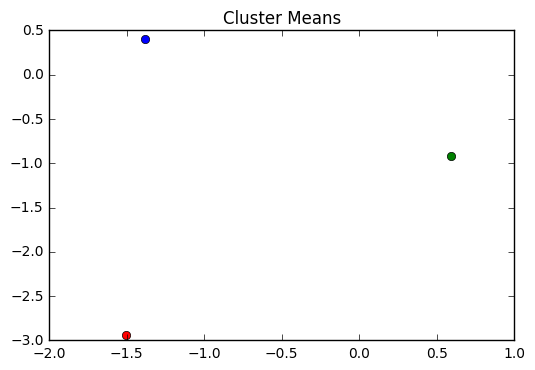

c_counts [ 10  70 220]


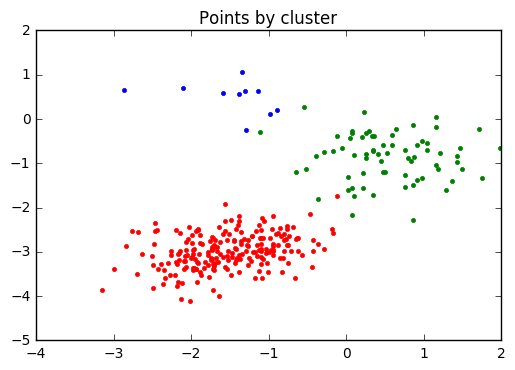

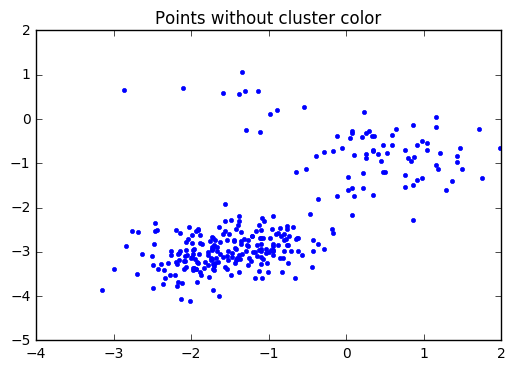

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

alpha = 1
D = 2
K = 3
N = 300

np.random.seed(122)

# draw theta, from uniform prior, using Dirichlet Distribution
# this uses the method from section 2.3 of the Frigyik, Kapila and Gupta tutorial earlier
gammas = np.random.gamma(alpha/K, 1, size=(K,))
# normalize to pdf
theta = gammas / np.sum(gammas)
print('theta', theta)

# draw gaussian means, for each cluster
gaussian_means = np.random.randn(K, 2)

# plot the means
for k in range(K):
    plt.plot(gaussian_means[k, 0], gaussian_means[k, 1], 'o')
plt.title('Cluster Means')
plt.show()

# draw gaussian covariance matrix, for each cluster
gaussian_covariances = np.random.randn(K, D, D)
# make positive semi-definite:
for k in range(K):
    gaussian_covariances[k] = gaussian_covariances[k].T.dot(gaussian_covariances[k])
# increase the diagonal a bit, so not too thin
for k in range(K):
    gaussian_covariances[k] += np.identity(D)
# shrink a bit, so dont dwarf the difference in means:
for k in range(K):
    gaussian_covariances[k] /= 8

# draw a distribution over classes:
c_counts = np.random.multinomial(N, theta)
print('c_counts', c_counts)

# draw points:
X = np.zeros((N, 2), dtype=np.float32)
n = 0
X_by_class = []
for c, count in enumerate(c_counts):
    samples = multivariate_normal.rvs(mean=gaussian_means[c], cov=gaussian_covariances[c], size=(count,))
    X[n: n+count] = samples
    X_by_class.append(samples)
    n += count

# plot by class:
for c in range(K):
    plt.plot(X_by_class[c][:, 0], X_by_class[c][:, 1], '.')
plt.title('Points by cluster')
plt.show()
    
# plot without class colors:
plt.plot(X[:, 0], X[:, 1], '.')
plt.title('Points without cluster color')
plt.show()

## Estimating parametric mixture models

(This bit is mostly from section 19.2 of [Cosma Shalizi's book](http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/) )

Probability of observing our data given parameters is:

$$p(\mathbf{X} \mid \mathbf{\theta}) = \prod_{i=1}^n f(\mathbf{x}_i, \mathbf{\phi})$$

We can take `log`s, to turn multiplication into addition:

$$\log p(\mathbf{X} \mid \mathbf{\theta}) = \sum_{i=1}^n \log f(\mathbf{x}_i, \mathbf{\phi})$$

$$= \sum_{i=1}^n \log \sum_{j=1}^k \theta_k f(\mathbf{x}_i, \mathbf{\phi}_k)$$

Let's take derivative wrt some parameter, eg $\phi_l$.

The derivative of log function is:

$$ \frac{\partial \log(f(x))}{\partial x} = \frac{\partial f(x) / \partial x}{f(x)} $$

Meanwhile, all the terms in $f(x, \phi_k)$ where $k \ne l$ will vanish.

So:

$$\frac{ \partial\, p(\mathbf{X} \mid \mathbf{\theta}) }{\partial \, \phi_l} = \sum_{i=1}^n \frac{\theta_l \, \partial f(\mathbf{x}, \phi_l)}{\partial \phi_l}\frac{1}{\sum_{j=1}^k \theta_j \, f(\mathbf{x}_i, \phi_j)} $$
$$= \sum_{i=1}^n
\frac{\theta_l}{\sum_{j=1}^k\theta_j\, f(\mathbf{x}_i, \phi_j)}
\frac{f(\mathbf{x}_i, \phi_l)}{f(\mathbf{x}_i, \phi_l)}
\frac{\partial \, f(\mathbf{x}_i, \phi_l)}{\partial \phi_l}
$$

$$
= \sum_{i=1}^n
\frac{\theta_l \,f(\mathbf{x}_i, \phi_l)}{\sum_{j=1}^k \theta_j \, f(\mathbf{x}_i, \phi_j)}
\frac{\partial\,\log f(\mathbf{x}_i, \phi_l)}{\partial \, \phi_l}
$$

If we had an ordinary, non-mixture, parametric model, the joint probability would look like:

$$ p(\mathbf{X}, \phi) = \prod_{i=1}^n f(\mathbf{x}, \phi) $$
So:
$$\log p(\mathbf{X}, \phi)=\sum_{i=1}^n \log f(\mathbf{x}_i, \phi)$$

...and in this case there are no latent variables, $\theta$, and so the derivative wrt $\phi_l$ is:

$$\frac{\partial \, \log p(\mathbf{X}, \phi)}{\partial \, \phi_l}
= \sum_{i=1}^n \frac{\partial \log f(\mathbf{x}_i, \phi_l)}{\partial \, \phi_l}
$$

So, by comparison of the mixture-model case with the non-mixture case, the mixture-model case has the same form, but with weights:

$$w_{i,l} = \frac{\theta_l \, f(\mathbf{x}_i, \phi_l)}{\sum_{j=1}^k \theta_j \, f(\mathbf{x}_i, \phi_j)}$$

$$=\frac{p(Z=l, X=\mathbf{x}_i)}{p(X=\mathbf{x}_i)}$$
$$= p(Z=l \mid X=\mathbf{x}_i)$$

So, we will iterate:

- given an estimate of $Z$ assignments, estimate $\phi$
- given an estimate of $\phi$, estimate $Z$ assignments

# Latent class models

Going back to the Griffiths and Ghahramani tutorial, let's start looking at latent class models.  Note that notation is slightly different from the Frigjik, Kapila and Gupta tutorial above.  Concretely:

- $\mathbf{q}$ in Frigjik et al tutorial becomes $\mathbf{\theta}$ in Griffiths and Ghahramani tutorial
  
$N$ objects, $i$th object has $D$ observable properties, represented by row vector $\mathbf{x}_i$.  Each object belongs to single class $c_i$, and properties $\mathbf{x}_i$ are generated from a distribution determined by that class.  Matrix $\mathbf{X} = \left[ \mathbf{x}_1^T \mathbf{x}_2^T \dots \mathbf{x}_N^T \right]^T$ represents properties of all $N$ objects, and vector $\mathbf{c} = \left[c_1 c_2 \dots c_N \right]^T$ represents thei class assignments.

## Finite mixture models

$$P(\mathbf{c} \mid \theta) = \prod_{i=1}^N P(c_i \mid \theta) = \prod_{i=1}^N \theta_{c_i}$$

... where $\theta$ is a multinomial distribution over those classes, and $\theta_k$ is the probability of class $k$ under that distribution.

Probability of all $N$ objects $\mathbf{X}$ can be written as:

$$p(\mathbf{X} \mid \theta) = \prod_{i=1}^N \sum_{k=1}^K p(\mathbf{x}_i \mid ci = k) \, \theta_k$$

The distribution from which each $\mathbf{x}_i$ is generated is thus a mixture of the $K$ class distributions $p(\mathbf{x}_i \mid c_i = k)$, with each $\theta_k$ determining the weight of class $k$.

Probability density for parameter $\theta$ of a multinomial distribution is given by:

$$p(\theta \mid \mathbf{\alpha}) = \frac{\prod_{k=1}^K \theta_k^{\alpha_{k=1}}}{D(\alpha_1,\alpha_2,\dots,\alpha_K)}$$

where $D(\alpha_1,\alpha_2,\dots,\alpha_K)$ is the Dirichlet normalizing constant:

$$D(\alpha_1, \alpha_2, \dots,\alpha_K) = \int_{\Delta_K}\prod_{k=1}^K\theta_k^{\alpha_k-1}d\theta $$
$$=\frac{\prod_{k=1}^K\Gamma(\alpha_k)}{\Gamma\left( \sum_{k=1}^K\alpha_k \right)}$$

Let's take $\alpha_k = \frac{\alpha}{K}$, for all $k$.  Then, we have:

$$D(\alpha/K, \alpha/K, \dots,\alpha/K) = \frac{\Gamma(\alpha/K)^K}{\Gamma(\alpha)}$$

Probability model is:

$$\theta \mid \alpha \sim \mathrm{Dirichlet}(\alpha/K, \alpha/K, \dots, \alpha/K)$$

$$c_i \mid \theta \sim \mathrm{Discrete}(\theta)$$


### Marginalizing over $\theta$

Marginalizing over all values of $\theta$:

We have:

$$P(\mathbf{c}) = \int_{\Delta_K} P(\mathbf{c} \mid \theta)\, p(\theta) d\theta$$

And:

$$P(\mathbf{c} \mid \theta) = \prod_{i=1}^n P(c_i \mid \theta)$$
$$=\prod_{i=1}^n \theta_{c_i}$$

Whilst, $p(\theta)$ is:

$$p(\theta) = \frac{\prod_{k=1}^K \theta_k^{\alpha/K - 1}}{D(\alpha/K,\alpha/K,\dots,\alpha/K)}$$

So, we have:

$$P(\mathbf{c}) = \int_{\Delta_K} 
\left(\prod_{i=1}^n \theta_{c_i} \right)
\frac{\prod_{k=1}^K \theta_k^{\alpha/K - 1}}{D(\alpha/K,\alpha/K,\dots,\alpha/K)}
d\theta
$$

We have two terms in $\theta$, and we want to take advantage of the Dirichlet being conjugate to multinomial.  So, we want to somehow combine these terms.

If we define:

$$m_k = \sum_{i=1}^N \delta(c_i = k)$$

Then the product over $n$, on the left becomes a product over $k$:

$$
\prod_{i=1}^n \theta_{c_i} = \prod_{k=1}^K \theta_k^{m_k}
$$

And so we get:

$$P(\mathbf{c}) = \int_{\Delta_K} 
\frac{\prod_{k=1}^K \theta_k^{m_k + \alpha/K - 1}}{D(\alpha/K,\alpha/K,\dots,\alpha/K)}
d\theta
$$

$D(\alpha/K, \dots)$ is independent of $\theta$, so we have:

$$P(\mathbf{c}) = \frac{1}{D(\alpha/K,\alpha/K,\dots,\alpha/K)}
\int_{\Delta_K} \prod_{k=1}^K \theta_k^{m_k + \alpha/K - 1} d\theta
$$

And we have:

$$\int_{\Delta_K} \prod_{k=1}^K \theta^{\alpha_k} = D(\alpha_1,\dots,\alpha_k)$$

(for some $\alpha$, $\theta$, $K$), and so:

$$P(\mathbf{c}) = \frac{1}{D(\alpha/K,\alpha/K,\dots,\alpha/K)}
D(m_1 + \alpha/K, m_2 + \alpha/K, \dots, m_k + \alpha_K)
$$

We can expand this in terms of the Gamma function $\Gamma$, since we have:

$$D(\alpha_1, \alpha_2,\dots,\alpha_k)
= \frac{\prod_{k=1}^K\Gamma(\alpha_k)}{\Gamma\left( \sum_{k=1}^K \alpha_k \right)}
$$

And so we have:

$$P(\mathbf{c}) =
\frac{\Gamma\left( \sum_{k=1}^K \alpha/K \right)}{\prod_{k=1}^K \Gamma \alpha/K}
\frac{\prod_{k=1}^K \Gamma (m_k + \alpha/K)}{\Gamma\left( \sum_{k=1}^K (m_k + \alpha/K ) \right)}
$$

$$
=
\frac{\Gamma\left( \alpha \right)}{\left( \Gamma \left(\frac{\alpha}{K}\right) \right)^K }
\frac{\prod_{k=1}^K \Gamma (m_k + \alpha/K)}{\Gamma\left( n + \alpha ) \right)}
$$

Lets plug in some concrete numbers:

In [31]:
import numpy as np
import math
from scipy.special import gamma

alpha = 1
M = [1, 1, 1]

def calc_p_c(alpha, M):
    N = np.sum(M)
    K = len(M)
    res = gamma(alpha)
    res /= math.pow(gamma(alpha/K), K)
    res /= gamma(N + alpha)
    for k, m in enumerate(M):
        res *= gamma(m + alpha/K)
    print('alpha', alpha, 'prob %.3f' % res, 'odds 1 in %.1f' % (1/res))

calc_p_c(alpha=1, M=[1,1,1])

alpha 1 prob 0.006 odds 1 in 162.0


Thats interesting.  Its not 1/27.  Let's try some different $\alpha$ values:

In [32]:
calc_p_c(alpha=0.1, M=[1,1,1])
calc_p_c(alpha=0.001, M=[1,1,1])

alpha 0.1 prob 0.000 odds 1 in 6237.0
alpha 0.001 prob 0.000 odds 1 in 54081027.0


Ok.  So, small values of $\alpha$ make it increasingly unlikely that the count in each class will be identical.  Let's try high values of $\alpha$:

In [33]:
calc_p_c(alpha=1000, M=[1,1,1])
calc_p_c(alpha=100, M=[1,1,1])
calc_p_c(alpha=10, M=[1,1,1])

alpha 1000 prob nan odds 1 in nan
alpha 100 prob 0.036 odds 1 in 27.8
alpha 10 prob 0.028 odds 1 in 35.6


/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


Ok, so high-ish values of $\alpha$, not so high as to cause nan, but high enough to favor uniform draws of $\theta$, recover a similar probability as we got right at the start of these notes, using uniform $\theta$.

What happens for $M = [3, 0, 0]$?  Is it the case that the probability is assymptotic to $1/3$ as $\alpha$ tends to $0$?


In [34]:
calc_p_c(alpha=1, M=[3, 0, 0])
calc_p_c(alpha=0.1, M=[3, 0, 0])
calc_p_c(alpha=0.001, M=[3, 0, 0])

alpha 1 prob 0.173 odds 1 in 5.8
alpha 0.1 prob 0.303 odds 1 in 3.3
alpha 0.001 prob 0.333 odds 1 in 3.0


Yes :-)

And presumably tends to $0$ as $\alpha$ increases?

In [35]:
calc_p_c(alpha=100, M=[3, 0, 0])
calc_p_c(alpha=150, M=[3, 0, 0])

alpha 100 prob 0.039 odds 1 in 25.5
alpha 150 prob 0.039 odds 1 in 26.0


No.  Tends to 1 in 27.  That makes sense: it's the probability of drawing 3 of a specific class when $\theta$ is uniform.

## Infinite mixture models

Per the tutorial, we should take the equation for $p\mathbf{c}$, and use the recursion $\Gamma(x) = (x-1)\Gamma(x - 1)$ to rearrange this, using the following new variables and constraints/assumptions:

- new variable: $K^+$ is number of classes with $m_k > 0$
- constraint/assumption: $k$ has been re-arranged, so $m_k > 0$ for all $k \le K^+$

I'm going to try that now, without looking at the solution.  My initial solution/derivation is on the next line though, if you want to avoid looking first :-)  edit: ok, I cheated, and looked at the solution somewhat.  So, what we want to do is:

- remove the $\Gamma$s from the left-hand fraction
- the right-hand expression is left unchanged

So, let's look just at the left-hand fraction (and this was my first draft, so there are mistakes in it, but maybe you can spot them :-)

$$
\frac
  {\prod_{k=1}^K \Gamma(m_k + \alpha/K)}
  {\left( \Gamma( \alpha/k) \right)^K}
$$

$$
=
\frac
  {\left(\prod_{k=1}^{K^+} \Gamma(m_k + \alpha/K)\right)  \left(\prod_{k=K^+ + 1}^{K} \Gamma(\alpha/K)\right)}
  {\left( \Gamma( \alpha/k) \right)^{K^+} \left( \Gamma( \alpha/k) \right)^{K - K^+ - 1} }
$$
$$
=
\frac
  {\left(\prod_{k=1}^{K^+} \Gamma(m_k + \alpha/K)\right)  \left( \Gamma(\alpha/K)\right)^{K - K^+ - 1}}
  {\left( \Gamma( \alpha/k) \right)^{K^+} \left( \Gamma( \alpha/k) \right)^{K - K^+ - 1} }
$$
$$
=
\frac
  {\left(\prod_{k=1}^{K^+} \Gamma(m_k + \alpha/K)\right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

Now all the infinities in this fraction have gone.  Well except for $K$ in $\alpha/K$.  Continuing, presumably we want the $\Gamma(\alpha/K)$ to cancel somehow?  So we should probably dabble in trying to move the $m_k$ to outside of the $\Gamma(\cdot)$s, in the numerator?

$$
=
\frac
  {\left(\prod_{k=1}^{K^+} (m_k + \alpha/K - 1)\Gamma(m_k - 1 + \alpha/K)\right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

$$
=
\frac
  {\left(\prod_{k=1}^{K^+} \prod_{i=1}^{m_k}(i + \alpha/K - 1)\Gamma( \alpha/K)\right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

$$
=
\frac
  {  \left(\prod_{k=1}^{K^+} (\Gamma(\alpha/K))^{m_k} \prod_{i=1}^{m_k}(i + \alpha/K - 1) \right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

$$
=
\frac
  { (\Gamma(\alpha/K))^{N} \left(\prod_{k=1}^{K^+}  \prod_{i=1}^{m_k}(i + \alpha/K - 1) \right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

At this point, I looked at the answer.  The product $\prod_{i=1}^{m_k}$ is slightly different, but similar:
$$
\prod_{i=1}^{m_k - 1} (i + \alpha/K)
$$

Basically, they put the $-1$ in the upper limit, instead of in the expresssion, which is just an arbitrary choice.  However, my lower bound was off by 1.

Somehow, they have elimated the remaining $\Gamma$s.  So, let's look just at that part:
$$
\frac
  { (\Gamma(\alpha/K))^{N} }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

Oh, because there the implied parentheses earlier were wrong.  I put:

$$
=
\frac
  {\left(\prod_{k=1}^{K^+} \prod_{i=1}^{m_k}(i + \alpha/K - 1)\Gamma( \alpha/K)\right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

with implied parantheses like:
$$
=
\frac
  {\left(\prod_{k=1}^{K^+} \prod_{i=1}^{m_k}\left( (i + \alpha/K - 1)\Gamma( \alpha/K) \right) \right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

...but in fact, the $\Gamma(\cdot)$ on the right-hand side should not be inside the product over $i$.  It should look like:
$$
=
\frac
  {\left(\prod_{k=1}^{K^+} \Gamma( \alpha/K) \prod_{i=1}^{m_k} (i + \alpha/K - 1) \right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

and applying the fix for the product over $i$:
$$
=
\frac
  {\left(\prod_{k=1}^{K^+} \Gamma( \alpha/K) \prod_{i=1}^{m_k - 1} (i + \alpha/K) \right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

... but then the $\Gamma(\alpha/K)^{K^+}$ will cancel entirely, but we need a term in $\alpha/K$, per the tutorial.  Unless... my bounds earlier on the product over $i$ were right, and they've taken the final term, without the $i$ to outside of the products.  ie,:

$$
\frac
  {\left(\prod_{k=1}^{K^+} \Gamma( \alpha/K) \prod_{i=0}^{m_k - 1} (i + \alpha/K) \right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$
$$
= 
\frac
  {\left(\prod_{k=1}^{K^+} \Gamma( \alpha/K) (\alpha/K)\prod_{i=1}^{m_k - 1} (i + \alpha/K) \right)  }
  {\left( \Gamma( \alpha/K) \right)^{K^+} }
$$

$$
= 
  (\alpha/K)^{K^+} \left( \prod_{k=1}^{K^+} \prod_{i=1}^{m_k - 1} (i + \alpha/K) \right)
$$

.... as required, giving the full expression for $P(\mathbf{c})$ as:

$$
P(\mathbf{c}) =
  (\alpha/K)^{K^+} \left( \prod_{k=1}^{K^+} \prod_{i=1}^{m_k - 1} (i + \alpha/K) \right)
  \frac {\Gamma( \alpha )}
        {\Gamma( N + \alpha )}
$$

As stated in the tutorial, this probability will go to 0, as $K$ goes to infinity.  It doesn't say why, but I assume because of the term in $\alpha/K$, at the start.  This presumably is why this term was moved outside the product over $i$?  For other values of $i$, the terms in the product over $i$ are all non-zero, but this term goes to zero, and that drives the entire product to zero. This term wouldnt necessarily drive the product to zero if at least one of the other terms in the product goes to infinity, but they dont.  $\alpha$ and $N$ are both finite.  And $i$ is in the range $1 \le i \le N$, which is finite, since $N$ is finite.


### Assignment vector equivalence classes

The tutorial states that in order to make the probability not go to 0 as $K \to \infty$, we should look not at the probability of specific assignments of $k$ indexes, but to the possible arrangements of subsets.  I initially interpreted this to mean that eg the following $\mathbf{c}$ assignment vectors are equivalent, since each has one subset of $2$ and one subset of size $1$:

- $\mathbf{c} = {2, 1, 2}$
- $\mathbf{c} = {2, 2, 1}$

However, in retrospect, based on the numbers coming out later, it looks like in fact the equivalence classes are for different ways of indexing the classes, whilst preserving the sets of objects assigned to the same class as each other.  Concretely, the following assignments are in the same equivalence partition:

- $\mathbf{c} = {2, 2, 1}$
- $\mathbf{c} = {1, 1, 2}$
- $\mathbf{c} = {333, 333, 111}$

But the following assignments are in different equivalence partitions, despite having the same subset sizes:

- $\mathbf{c} = {2, 1, 2}$
- $\mathbf{c} = {1, 2, 2}$

In hindsight, this makes sense, because our goal is not to come up with a purely generative model, but to fit the model to actual data, to assign data points to clusters.  So, for example, the first two points might be really near each other, and in one cluster, and the third point could be in a second cluster.  Using ascii graphics:

```
   cluster 1:                                           cluster 2:
   x_1    x_2                                           x_3
```

So, the probability of assigning the first two points to a cluster, versus points 1 and 3 to a cluster should be radically different, not identical.  However, there's no reason why the first cluster, on points 1 and 2, should be indexed as $1$ or $111$ or $12345$, or whatever:

```
   cluster 1:                                           cluster 2:
   x_1    x_2                                           x_3
   k=1    k=1                                           k=2
```
same partition as:
```
   cluster 1:                                           cluster 2:
   x_1    x_2                                           x_3
   k=3333  k=3333                                       k=12345
```

The fact that the actual class index assignment to each cluster doesnt change the probability of that cluster is what the partition equivalence captures.

Then, per the tutorial, we define a variable $K_0$, where $K = K^0 + K^+$, and $K$ and $K^+$ are as before.  So, $K^0$ is the count of the classes that have no elements.  The tutorial asserts that the number of equivalent ways of arranging these $K^+$ classes is $K! / K_0!$.  Working backwards, this is the number of permutations:

number of equivalent assignment vectors of $\mathbf{c}$ = $K! / K_0!$ = $K / (K - K^+)!$ = $\left( ^KP_{K^+} \right)$

So, we are counting the number of ways of arranging $K^+$ items over $K$ possible positions, and taking into account the various possible orders of the $K^+$ elements.  I didnt get this originally, because I was interpreting the partitioning differently.

Then, we multiply this by the earlier formula, to get the probability of each equivalence class, $[\mathbf{c}]$:

$$
P([\mathbf{c}] \mid \alpha)
= \frac{K!}{K_0!} 
  \left( \frac{\alpha}{K} \right)^{K^+}
  \left( \prod_{k=1}^{K^+} \prod_{i=1}^{m_k - 1} (i + \alpha/K) \right)
  \frac {\Gamma( \alpha )}
        {\Gamma( N + \alpha )}
$$

The tutorial then rearranges the left-hand terms a bit:

$$
P([\mathbf{c}] \mid \alpha)
=
\alpha^{K^+}
\frac{K!}{K_0! K^{K^+}} 
  \left( \prod_{k=1}^{K^+} \prod_{i=1}^{m_k - 1} (i + \alpha/K) \right)
  \frac {\Gamma( \alpha )}
        {\Gamma( N + \alpha )}
$$

Looking at what happens as $K \to \infty$, looking first at the term on the left:

$$
\frac{K!}{K_0! K^{K^+}} 
$$

I originally assumed that $\frac{K!}{K_0!} \to 1$, since $K/K_0 \to 1$.  But that turns out not to be quite right:

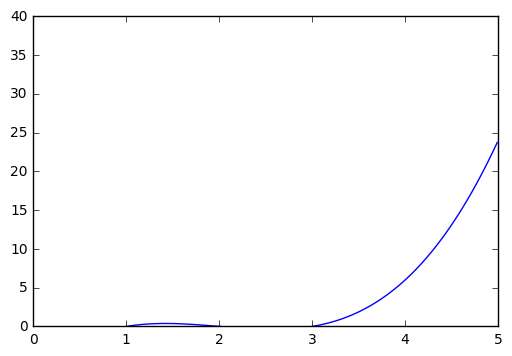

In [76]:
from scipy.special import gamma
import matplotlib.pyplot as plt
import numpy as np


def plot_K_over_K0(K_plus=3):
    X = np.arange(0.01, 5, 0.01)
    y = gamma(X) / gamma(X - K_plus)
    plt.plot(X, y)
    plt.ylim(0, 40)
    plt.show()
plot_K_over_K0()

Makes sense, since $\frac{K!}{K_0!}$ will always be a product like:

$$K(K-1)(K-2)\dots K_0$$

The number of terms in this product is constant, and finite.  However, each term itself tends to $\infty$ as $K \to \infty$.  So $\frac{K!}{K_0!}$ actually tends to $\infty$.

However, empirically, $\frac{K!}{K_0!K^{K^+}} \to 1$, as $K \to \infty$:

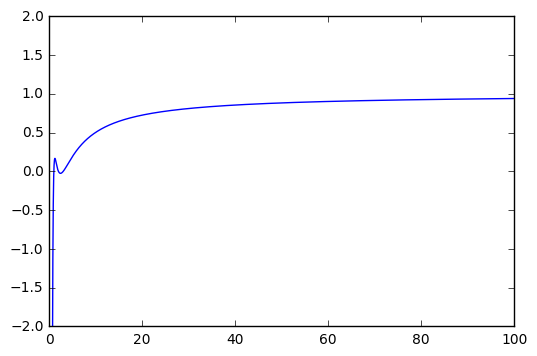

In [85]:
from scipy.special import gamma
import matplotlib.pyplot as plt
import numpy as np


def plot_K_over_K0_over_K_Kplus(K_plus=3):
    X = np.arange(0.01, 100, 0.01)
    y = gamma(X) / gamma(X - K_plus) / np.power(X, K_plus)
    plt.plot(X, y)
    plt.ylim(-2, 2)
    plt.show()
plot_K_over_K0_over_K_Kplus()

How to prove this is the case?

We have:

$$
\frac{K!}{K_0!K^{K^+}}
$$

Expanding out the factorial terms we have:

$$
\frac
  {K(K-1)(K-2)\dots(K_0)}
  {K^{K^+}}
$$

The number of terms in the numerator is $K^+$, since $K - K_0 = K^+$.  And expanding the power on the denominator we have:

$$
\frac
  {K(K-1)(K-2)\dots(K_0)}
  {\prod_{k=1}^{K^+} K}
$$

We can pair each term on the numerator with one on the denominator like:

$$
\prod_{k=1}^{K^+} \frac
   {K - k + 1}
   {K}
$$

$k$ is in range $1 \le k \le K^+$, and $K^+$ is finite, so $\frac{K - k + 1}{K} \to 1$ as $K \to \infty$.

Therefore the product of $\frac{K- k + 1}{K}$ also $\to \infty$.  Therefore:

$\frac{K!}{K_0!K^{K^+}} \to 1$, as $K \to \infty$

Slotting this into the expression for $P([\mathbf{c}])$, we get:

$$
$$

${K^+}$ is finite, $\le N$, and $K!$ will grow faster than $K^{\mathrm{finite\,constant}}$, and approximately the same as $K_0!$, so this term $\to 1$

Then, in the product over $i$, the term $i + \alpha/K$ will tend to $i$, as $K \to \infty$, so the product term becomes:

$$
\prod_{i=1}^{m_k - 1} i
$$
$$=(m_k - 1)!$$

And so the final probability of each equivalence class $[\mathbf{c}]$ is:

$$
\alpha^{K^+}
\prod_{k=1}^{K^+} (m_k - 1)!
\frac
  {\Gamma(\alpha)}
  {\Gamma(N + \alpha)}
$$

... as stated by the tutorial.


Lets try slotting in some numbers, as before:

In [49]:
import math
from scipy.special import gamma

def print_p_c_equiv(alpha, M):
    N = np.sum(M)
    K_plus = len(M)
    res = math.pow(alpha, K_plus)
    for k, m in enumerate(M):
        res *= math.factorial(m - 1)
    res *= gamma(alpha)
    res /= gamma(N + alpha)
    odds = 1 / res
    print('probability alpha=%s M=%s is %s, 1 in %s' % (
        alpha, str(M), res, odds
    ))

print_p_c_equiv(1, [1, 1, 1])
print_p_c_equiv(1, [2, 1])
print_p_c_equiv(1, [1, 2])
print_p_c_equiv(1, [1, 2])
print_p_c_equiv(1, [3])

print_p_c_equiv(0.1, [1, 1, 1])
print_p_c_equiv(0.01, [1, 1, 1])

print_p_c_equiv(100, [1, 1, 1])

print_p_c_equiv(100, [2, 1])
print_p_c_equiv(100, [3])


probability alpha=1 M=[1, 1, 1] is 0.166666666667, 1 in 6.0
probability alpha=1 M=[2, 1] is 0.166666666667, 1 in 6.0
probability alpha=1 M=[1, 2] is 0.166666666667, 1 in 6.0
probability alpha=1 M=[1, 2] is 0.166666666667, 1 in 6.0
probability alpha=1 M=[3] is 0.333333333333, 1 in 3.0
probability alpha=0.1 M=[1, 1, 1] is 0.004329004329, 1 in 231.0
probability alpha=0.01 M=[1, 1, 1] is 4.9258657209e-05, 1 in 20301.0
probability alpha=100 M=[1, 1, 1] is 0.970685303825, 1 in 1.0302
probability alpha=100 M=[2, 1] is 0.00970685303825, 1 in 103.02
probability alpha=100 M=[3] is 0.000194137060765, 1 in 5151.0


I had to stare at these numbers for a while, mostly because I was interpreting the partitions wrongly, as per first paragraph above.  Why are the numbers different from the earlier results, where we fixed $K$ to be $3$?  After updating my interpretation of partitioning they made more sense.

For high alpha, what is happening, I think, is that $\theta$ is uniform, and means that the assignment of each class number to an object will be drawn from the range $1 \le k \le \infty$.  This overwhelmingly favors drawing a different class number for each object.  And so, the probability that each object is in a differnet class, ie three subsets of 1, tends to $1$, as $\alpha \to \infty$.

What about when $\alpha$ is $1$?  Why dont the probabilities of $[\mathbf{c}] = \{1, 1, 1\}$, $[\mathbf{c}] = \{2, 1\}$ and $[\mathbf{c}] = \{3\}$ add up to 1.0?  After revising my interpretation of what is a partition, this made more sense than initially.

For $N=3$, we have the following partitions possible:

Partition with one subset of 3:

- $\mathbf{c} = {1, 1, 1}$

Partition with one subset of 2, over the first 2 items:

- $\mathbf{c} = {2, 2, 1}$

And two more partitions with subset of size 2:

- $\mathbf{c} = {2, 1, 2}$
- $\mathbf{c} = {1, 2, 2}$

And then we have a partition where each object is in a different subset of size 1:

- $\mathbf{c} = {1, 2, 3}$

So, there are 5 partitions in possible.  Going back to the numbers for $\alpha = 1$, the total probability will be:

- $P(M = \{1, 1, 1 \}) * 1$, plus
- $P(M = \{2, 1 \}) * 3$, plus
- $P(M = \{3 \}) * 1$

Which is:
$$(1/6) + (1/6)*3 + (1/3)$$
$$=1$$

... as required

Let's try low alpha values:

In [50]:
print_p_c_equiv(0.01, [1, 1, 1])
print_p_c_equiv(0.01, [2, 1])
print_p_c_equiv(0.01, [3])

probability alpha=0.01 M=[1, 1, 1] is 4.9258657209e-05, 1 in 20301.0
probability alpha=0.01 M=[2, 1] is 0.0049258657209, 1 in 203.01
probability alpha=0.01 M=[3] is 0.98517314418, 1 in 1.01505


So, the probability of getting one single subset of size $3$ tends to $1$, as $\alpha \to 0$

## Chinese Restaurant Process

$P(c_i = k \mid c_1, c_2, \dots, c_{i-1}) =$
- $\frac{m_k}{i - 1 + \alpha}$ when $k \le K^+$
- $\frac{\alpha}{i-1+\alpha}$ when $k = K + 1$


## Gibbs Sampling


### Finite mixture

We want $P(c_i \mid \mathbf{c}_{-i}, \mathbf{X})$

Reminder to self, Bayes Rule:

$$P(A \mid B) = \frac{P(B \mid A) \, P(A)} {P(B)}$$

By Bayes rule $P(c_i \mid \mathbf{c}_{-i}, \mathbf{X})$ is:

$$P(c_i \mid \mathbf{c}_{-i}, \mathbf{X})
\propto
\frac{ P(\mathbf{c}_{-i} \mid c_i, \mathbf{X})\, P(c_i \mid \mathbf{X})}
  {P(\mathbf{c}_{-i} \mid \mathbf{X})}
$$
 
 or:
 
$$P(c_i \mid \mathbf{c}_{-i}, \mathbf{X})
\propto
\frac{ P(\mathbf{X} \mid c_i, \mathbf{c}_{-i})\, P(c_i \mid \mathbf{c}_{-i} )}
  {P(\mathbf{X} \mid \mathbf{c}_{-i})}
$$
$$
= \frac{ P(\mathbf{X} \mid \mathbf{c})\, P(c_i \mid \mathbf{c}_{-i} )}
  {P(\mathbf{X} \mid \mathbf{c}_{-i})}
$$

The second one looks like the one we should use, but still, I couldnt really figure out the breadcrumbs at this point.  What does it mean "only the second term on the right hand side depends upon the distribution over class assignments $P(\mathbf{c})$"?  It seems like there is $\mathbf{c}$ in the left hand term $p(\mathbf{X} \mid \mathbf{c})$ too?  So, after staring at this for a bit, I looked around, and reached out to Neil's ["Markov Chain Sampling Methods for Dirichlet Process Mixture Models"](http://www.cs.princeton.edu/courses/archive/fall11/cos597C/reading/Neal2000a.pdf).  So let's go there.  The following is based on Neal's paper/report, until further notice.

### Revision: Dirichlet process mixture models

Neal presents a DP mixture model as:

$$y_i \mid \theta_i \sim F(\theta_i)$$

$$\theta_i \mid G \sim G$$

$$G \sim DP(G_o, \alpha)$$

So, this means:

- we have some base distribution, perhaps a gaussian, $G_0$
- we draw Dirichlet distributions, $G$, from this
- these look similar to $G_0$, in that their density follows approximately the same overall shape
- ... except they are discrete, not continuous

Let's draw a graph of this, in python, or try... let's start with $G_0$:

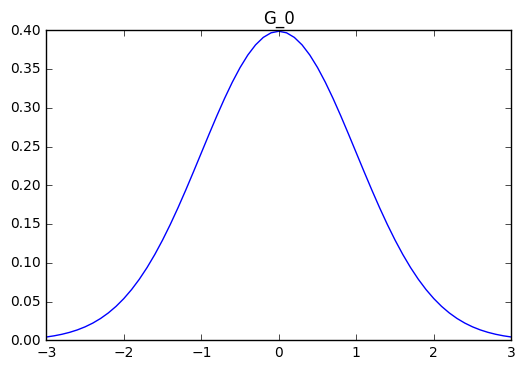

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats

def G_0(x):
    return scipy.stats.norm.pdf(x)

X = np.arange(-3, 3+0.1, 0.1)
plt.plot(X, G_0(X))
plt.title("G_0")
plt.ylim(0, 0.4)
plt.xlim(-3, 3)
plt.show()

We cant exactly draw G, since its infinite, but we can draw the first N values of theta from a draw G.  Skipping down to equation 2.2, in Neal, the CRP, we have:

$$\theta_i \mid \theta_1,\dots,\theta_{i-1} \sim
\frac
  {1}
  {i-1+\alpha}
\sum_{j=1}^{i-1}
  \delta(\theta_j)
+
\frac
  {\alpha}
  {i - 1 + \alpha}
G_0
$$

So, we can use this to sample $\theta$ from $G$, given $G_0$. I think

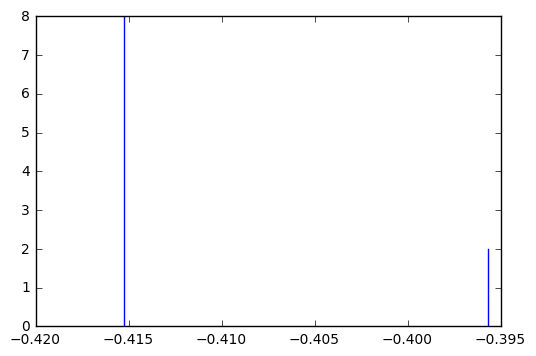

In [78]:
import random


# change G_0 a bit
class G_0(object):
    def pdf(self, x):
        return scipy.stats.norm.pdf(x)
    
    def rvs(self):
        return scipy.stats.norm.rvs()

def draw_thetas(alpha, N):
    random.seed(123)

    M = []  # using notation from Griffiths and Ghahramani
    thetas = []  # list of the theta draws, should be same length as M

    g0 = G_0()
    for i in range(N):
        cumMPdf = np.cumsum(M) / ((i + 1) - 1 + alpha)
        uniform_rand = random.uniform(0, 1.0)
        target_k = None
        for k, m in enumerate(M):
            if uniform_rand <= cumMPdf[k]:
                target_k = k
                break
        if target_k is None:
            # draw new cluster
            # get a value of theta, from G_0
            # at this point, I changed G_0 into a class, above
            theta_draw = g0.rvs()
            thetas.append(theta_draw)
            M.append(1)
        else:
            # simply increase size of existing cluster
            M[target_k] += 1

    # Now we need to plot these
    # The thetas are along the x-axis
    # and the M values are the y
    # we'll be plotting vertical lines

    for k, theta in enumerate(thetas):
        x = theta
        y = M[k]
        plt.plot([x, x], [0, y], '-b')
    plt.show()

draw_thetas(alpha=1, N=10)

Cool. Let's increase N a bit...

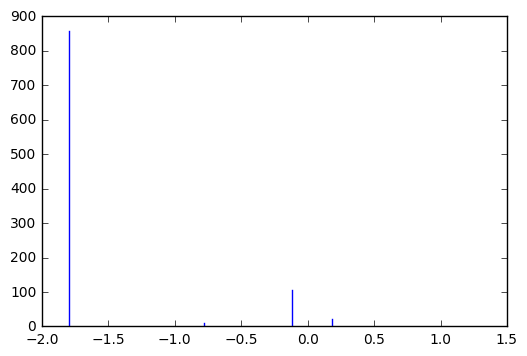

In [89]:
draw_thetas(alpha=1, N=1000)

Not really what I was imagining.  Let's try reducing alpha:

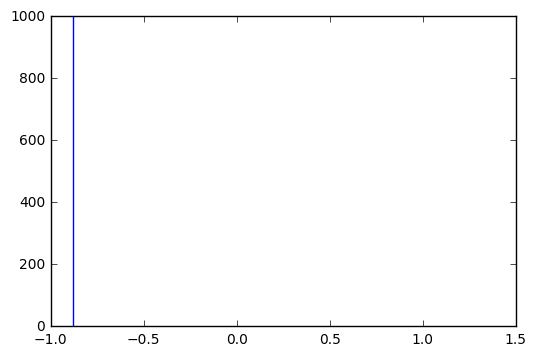

In [90]:
draw_thetas(alpha=0.1, N=1000)

No better.  Increasing it?

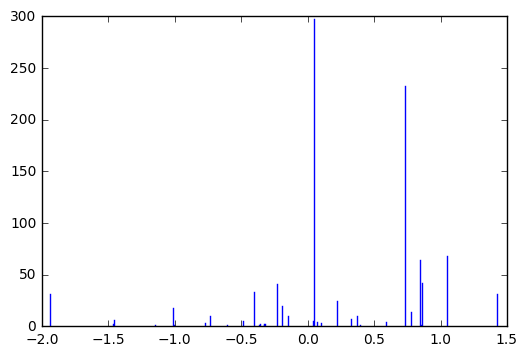

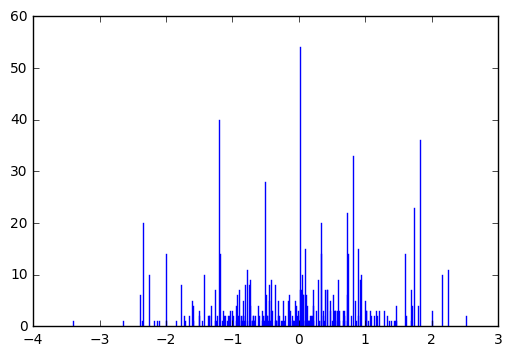

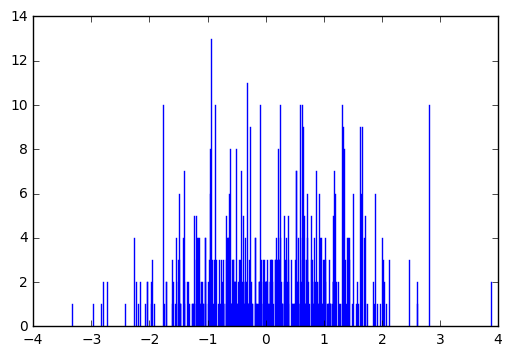

In [94]:
draw_thetas(alpha=10, N=1000)
draw_thetas(alpha=100, N=1000)
draw_thetas(alpha=300, N=1000)

Thats kind of more like what I had in mind :-)

So, the draws of $\theta$, from $G$, drawn from $G_0$ kind of follow $G_0$, but they are discrete. The density of the spikes, for finite $N$, increases with increasing $\alpha$.  The spikes are very few indeed for $\alpha$ of $1$ or less.

Note that what we are plotting here is the count of the $\theta$ draws, with $\theta$ along the x-axis, and the count of $\theta$ draws vertically.  Going back to the formulation earlier, we will draw $y$ values, based on the $\theta$ values:

$$y_i \mid \theta_i \sim F(\theta_i)$$

$$\theta_i \mid G \sim G$$

$$G \sim DP(G_o, \alpha)$$

The $\theta_k$ values are the parameters for a function $F(\theta_k)$.  $\theta_k$ will generally be a vector, but for the toy example above, is essentially a vector of size 1, and treated as a scalar.

The $\theta_k$ are then the parameters for for example gaussian distributions, where $F(\theta_k)$ is the distribution for each of these gaussians.

Neal then depicts finite models, using a similar notation:
    
$$y_i \mid c_i, \phi \sim F(\phi_{c_i})$$
$$c_i \mid \mathbf{p} \sim \mathrm{Discrete}(p_1,\dots,p_K)$$
$$\phi_c \sim G_0$$
$$\mathbf{p} \sim \mathrm{Dirichlet}(\alpha/K,\dots,\alpha/K)$$

So:

- $\mathbf{p}$ here is like the $\mathbf{\theta}$ in Griffiths and Ghahramani: it is the parameters for the distribution over classes
- flicking back through Griffiths and Ghahramani, Griffiths and Ghahramani never really make explicit the existence of $F(\cdot)$, $G_0$, or $\phi$, I think.  At least not in the bit I've read so far.  It just deals with assignment to classes, and not to the distribution over their $x$ for each class.  They just write for example $p(\mathbf{x}_i \mid c_i)$, which implies some kind of distribution, dependent on class $c_i$, but without saying what it is, or where it came from

At this point, Neal writes down the equation for $P(c_i=c \mid c_1,\dots,c_{i-1})$, equations 2.4 to 2.6, but I get lost trying to figure out how to get from equation 2.4 to 2.5.

I googled for "dirichlet process gibbs sampling", and my own question to stackexchange from years ago is the number one hit :-P  https://stats.stackexchange.com/questions/25645/simple-introduction-to-mcmc-with-dirichlet-process-prior :-D

I remember there was someting from Bob Carpenter, and googled for that, but that turns up something for LDA, ie ["Integrating Out Multinomial Parameters in Latent Dirichlet Allocation and Naive Bayes for Collapsed Gibbs Sampling"](https://lingpipe.files.wordpress.com/2010/07/lda3.pdf). There is a useful-looking factorization though, ie $\int (a \, b) \, da \, db = (\int a \, da)( \int b \, db)$ (as long as $a$ and $b$ are independent).

After browsing around, I noticed that the Neal equation is only for the finite model, no need for DPs, and so let's look more closely...

So, Neal states, equation 2.4:

$$P(c_i = c \mid c_1,\dots,c_{i-1})$$
$$= \frac{P(c_1,\dots,c_i)}{P(c_1,\dots,c_{i-1})}$$

So far, so good.  Then equation 2.5:

$$=\frac
  {\int p_{c_1},\dots,p_{c_{i-1}}p_c \Gamma(\alpha)(\Gamma(\alpha/K))^{-K} p_1^{\alpha-K-1},\dots,p_K^{\alpha/K-1}\,d\mathbf{p}} 
  {\int p_{c_1},\dots,p_{c_{i-1}} \Gamma(\alpha)(\Gamma(\alpha/K))^{-K} p_1^{\alpha-K-1},\dots,p_K^{\alpha/K-1}\,d\mathbf{p}}
$$

So, let's break this down.  The bit on the left, of the numerator, is the product of the probabilities $p(c_j | \mathbf{p})$, for $j=1,\dots,i$ which for each $i$ is simply $p_{c_i}$, giving $\prod_{j=1}^{i}p_{c_j}$.  Let's separate out the $p_{c_i}$, which is the only difference compared to the denominator, so we have:

$$=\frac
  {\int p_{c_i}\prod_{j=1}^{i-1}p_{c_j} \Gamma(\alpha)(\Gamma(\alpha/K))^{-K} p_1^{\alpha-K-1},\dots,p_K^{\alpha/K-1}\,d\mathbf{p}} 
  {\int\prod_{j=1}^{i-1}p_{c_j} \Gamma(\alpha)(\Gamma(\alpha/K))^{-K} p_1^{\alpha-K-1},\dots,p_K^{\alpha/K-1}\,d\mathbf{p}}
$$

The next bit, of the numerator, is the dirichlet prior, ie the $\Gamma$ of the sums, over the product of the $\Gamma$s, multiplied by the product of each parameter, to the power $\alpha_k - 1$, where here, the $\alpha_k$s are uniform, ie $\alpha/K$, ie:

$$
\frac
  {\Gamma(\sum_{k=1}^K \alpha_k)}
  {\prod_{k=1}^K(\Gamma( \alpha_k)}
  \prod_{k=1}^K p_k^{\alpha_k - 1}
$$
Substituting $\alpha_k = \alpha/K$, and moving the denominator of the fraction into the numerator, this is:

$$
\Gamma(\alpha)
(\Gamma(\alpha/K))^{-K}
\prod_{k=1}^K p_k^{\alpha/K-1}
$$

which, if we substitute into equation 2.4, gives us then equation 2.5:

$$=\frac
  {\int
    p_{c_i}\prod_{j=1}^{i-1}p_{c_j}
    \Gamma(\alpha)
    (\Gamma(\alpha/K))^{-K}
    \prod_{k=1}^K p_k^{\alpha/K-1}
    \,d\mathbf{p}
  }
  {\int
    \prod_{j=1}^{i-1}p_{c_j}
    \Gamma(\alpha)
    (\Gamma(\alpha/K))^{-K}
    \prod_{k=1}^K p_k^{\alpha/K-1}
    \,d\mathbf{p}
  }
$$


Then, Neal writes equation 2.6:

$$
\frac
  {n_{i,c} + \alpha/K}
  {i - 1 + \alpha}
$$

Ouch, thats a big step.  So, probably this involves the conjugate relationship of Dirichlet Distribution being the conjugate prior of the Multinomial distribution.  And glancing back at the Griffiths and Ghahramani tutorial, we have the following equation for an integration involving Dirichlet distributions:

$$\int_{\Delta_K} \prod_{k=1}^K \theta^{\alpha_k} = D(\alpha_1,\dots,\alpha_k)$$

Using Neal's notation, this becomes:

$$\int_{\Delta_K} \prod_{k=1}^K \mathbf{p}^{\alpha_k} = D(\alpha_1,\dots,\alpha_k)$$

And substituting in $\alpha_k = \alpha/K$, we get:

$$\int_{\Delta_K} \prod_{k=1}^K \mathbf{p}^{\alpha / K} = D(\alpha/K,\dots,\alpha/K)$$

The $D(\cdot,\dots,\cdot)$ expression is defined as:

$$D(\alpha_1,\dots,\alpha_k) =
\frac
  {\prod_{k=1}^K \Gamma(\alpha_k)}
  {\Gamma(\sum_{k=1}^K \alpha_k)}
$$

So:

$$
\int_{\Delta_K} \prod_{k=1}^K \mathbf{p}^{\alpha_k}=
\frac
  {\prod_{k=1}^K \Gamma(\alpha_k)}
  {\Gamma(\sum_{k=1}^K \alpha_k)}
$$

Substituting in $\alpha_k = \alpha/K$:

$$D(\alpha/K,\dots,\alpha/K) =
\frac
  {(\Gamma(\alpha_k))^K}
  {\Gamma(\alpha)}
$$

$$ = (\Gamma(\alpha_k))^K \Gamma(-\alpha)
$$

So:

$$
\int_{\Delta_K} \prod_{k=1}^K \mathbf{p}^{\alpha / K}
= (\Gamma(\alpha_k))^K \Gamma(-\alpha)
$$

Looking back at equation 2.5, anything that is not a function of $\mathbf{p}$ can be moved out of the integral.  That means the $\Gamma$s inside the integrals cancel, giving:

$$=\frac
  {\int
    p_{c_i}\prod_{j=1}^{i-1}p_{c_j}
    \prod_{k=1}^K p_k^{\alpha/K-1}
    \,d\mathbf{p}
  }
  {\int
    \prod_{j=1}^{i-1}p_{c_j}
    \prod_{k=1}^K p_k^{\alpha/K-1}
    \,d\mathbf{p}
  }
$$

And we need to get this in the form $\int p^{\mathrm{some\,expression}}\,d\mathbf{p}$, so that we can then write the result of the integral as $\Gamma$ functions.  Neal offers, just under equation (2.6), "where $n_{i,c}$ is the number of $c_j$ for $j < i$ that are equal to $c$".  This sounds remarkably like the $m_k$ of Griffiths and Ghahramani, so let's use this:

$$=\frac
  {\int
    p_{c_i}
    \prod_{k=1}^K p_k^{n_{i,k}}
    \prod_{k=1}^K p_k^{\alpha/K-1}
    \,d\mathbf{p}
  }
  {\int
    \prod_{k=1}^K p_k^{n_{i,k}}
    \prod_{k=1}^K p_k^{\alpha/K-1}
    \,d\mathbf{p}
  }
$$
$$=\frac
  {\int
    p_{c_i}
    \prod_{k=1}^K p_k^{n_{i,k + \alpha/K - 1}}
    \,d\mathbf{p}
  }
  {\int
    \prod_{k=1}^K p_k^{n_{i,k} + \alpha/K - 1}
    \,d\mathbf{p}
  }
$$

I dont reckon we can move the $p_{c_i}$ outside of the integral, since the integral is over $\mathbf{p}$.  But, what if we move $p_{c_i}$ into the product over $k$, in the numerator, handle the integration, then deal with the $\Gamma$s afterwards?  The numerator will look like:

$$
\int
    p_{c_i}
    \prod_{k=1}^K p_k^{n_{i,k} + \alpha/K - 1}
    \,d\mathbf{p}
$$
$$
=\int
    \prod_{k=1}^K p_k^{n_{i+1,k} + \alpha/K - 1}
    \,d\mathbf{p}
$$
Using the expression for such integrals, above, we get:
$$
= D(n_{i+1,1} + \alpha/K, \dots, n_{i+1,k} + \alpha/K)
$$
$$
= \frac
  {\prod_{k=1}^K \Gamma(n_{i+1,k} + \alpha/K)}
  {\Gamma(\sum_{k=1}^K(n_{i+1,k} + \alpha/K) )}
$$

Putting together with the denominator, from 2.5:

$$
= \frac
  {\prod_{k=1}^K \Gamma(n_{i+1,k} + \alpha/K)}
  {\Gamma(\sum_{k=1}^K(n_{i+1,k} + \alpha/K) )}
\frac
  {\Gamma(\sum_{k=1}^K(n_{i,k} + \alpha/K) )}
  {\prod_{k=1}^K \Gamma(n_{i,k} + \alpha/K)}
$$


There are two cases for $k$:

- $k = c_i$
- $k \ne c_i$

Looking at $n_{i,k}$ for these two cases:

- when $k \ne c_i$, $n_{i+1,k} = n_{i, k}$
- when $k = c_i$, $n_{i+1,k} = n_{i, k} + 1$

For simplicity of notation, let's rearrange the indices, so that $c_i = K$.  Then we have:

$$
= \frac
  {\Gamma(n_{i,K} + 1 + \alpha/K) \prod_{k=1}^{K-1} \Gamma(n_{i,k} + \alpha/K)}
  {\Gamma(n_{i,K} + 1 + \alpha/K + \sum_{k=1}^{K-1}(n_{i,k} + \alpha/K) )}
\frac
  {\Gamma(\sum_{k=1}^K(n_{i,k} + \alpha/K) )}
  {\prod_{k=1}^K \Gamma(n_{i,k} + \alpha/K)}
$$
$$
= \frac
  {\Gamma(n_{i,K} + 1 + \alpha/K) \prod_{k=1}^{K-1} \Gamma(n_{i,k} + \alpha/K)}
  {\Gamma(1 + \sum_{k=1}^{K}(n_{i,k} + \alpha/K) )}
\frac
  {\Gamma(\sum_{k=1}^K(n_{i,k} + \alpha/K) )}
  {\prod_{k=1}^K \Gamma(n_{i,k} + \alpha/K)}
$$
Using $\Gamma(x) = (x-1)\Gamma(x-1)$, on both top and bottom, of the left hand fraction, we get:
$$
= \frac
  {(n_{i,K} + \alpha/K)\Gamma(\prod_{k=1}^{K} \Gamma(n_{i,k} + \alpha/K)}
  {\sum_{k=1}^{K}(n_{i,k} + \alpha/K) \Gamma(\sum_{k=1}^{K}(n_{i,k} + \alpha/K) )}
\frac
  {\Gamma(\sum_{k=1}^K(n_{i,k} + \alpha/K) )}
  {\prod_{k=1}^K \Gamma(n_{i,k} + \alpha/K)}
$$
Cancelling the right-most two fractions:
$$
= \frac
  {(n_{i,K} + \alpha/K)}
  {\sum_{k=1}^{K}(n_{i,k} + \alpha/K)}
$$
Swapping back, so $K$ becomes $c$ (notation is a bit messy I agree...)
$$
= \frac
  {(n_{i,c} + \alpha/K)}
  {\sum_{k=1}^{K}(n_{i,k} + \alpha/K)}
$$
We have:
$$
\sum_{k=1}^K n_{i,k}
= i - 1
$$
So:
$$
= \frac
  {n_{i,c} + \alpha/K}
  {i - 1 + \alpha}
$$

As required :-)

As $K \to \infty$, for $c_i = c$:

$$P(c_i=c \mid c_1,\dots,c_{i-1}) \to \frac{n_{i,c}}{i - 1 + \alpha}$$

Neal says that for $c_i \ne c_j$ for all $j < i$:

$$P(c_i \ne c_j \mathrm{\,for\,all\,} j < i \mid c_1,\dots,c_{i-1}) \to \frac{\alpha}{i - 1 + \alpha}$$

I stared at this for a bit, thinking this meant $P(c_i \ne c \mid c_1,\dots,c_{i-1})$, ie $1 - P(c_i = c \mid c_1, \dots, c_{i-1})$, which didnt seem to give the asymptote stated. But actually, this means, the probability of drawing a class that doesnt match any of the previously drawn classes.  So, it means that $n_{i,c}$ will be $0$.  However, we have to add the probability across all previously drawn classes, ie multiply by $K$.  So, we'll have:

$$
P(c_i \ne c_j \mathrm{\,for\,all\,} j < i \mid c_1, \dots,c_{i-1})
$$
$$
\to
 K \frac{0 + \alpha/K}{i - 1 + \alpha}
$$
$$
= \frac{\alpha}{i - 1  + \alpha}
$$
as stated.


Leaving Neal, and returning to the Griffiths and Ghahramani tutorial, and rewriting the results from above in the notation of Griffiths and Ghahramani, we have:

$$P(c_i =k \mid \mathbf{c}_{-i}) = \frac{m_{-i,k} + \alpha/K}{N - 1 + \alpha}$$

where:

- Neal's $n_{i,j}$ becomes $m_{-i,k}$, and
- $i$ becomes $N$

And also, as $K \to \infty$:

$$P(c_i = k \mid \mathbf{c}_i) $$

$$= \frac{m_{-i,k}}{N - 1 + \alpha} \mathrm{\,when\,} m_{-i,k} > 0$$

$$= \frac{\alpha}{N - 1 + \alpha} \mathrm{\,when\,} k = K_{-i}^+ + 1$$

$$= 0 \mathrm{\,otherwise}$$


I'm tempted to dabble in finishing the Neal paper, but probably better to finish the Griffiths and Ghahramani tutorial, then decide where to go from there.

# Latent Feature Models

Latent feature values for $N$ objects:

$$\mathbf{F} = [\mathbf{f}_1^T \mathbf{f}_2^T\dots \mathbf{f}_N^T]^T$$

$$\mathbf{F} = \mathbf{Z} \odot \mathbf{V}$$

where:

- $\mathbf{Z}$ is binary matrix indicating which features are possessed by an object
- $\mathbf{V}$ indicates the value of each feature for each project
- $\odot$ indicates element-wise (Hadamard) product

Can specify prior on $\mathbf{Z}$ and $\mathbf{V}$ separately:

$$P(\mathbf{F}) = P(\mathbf{Z})P(\mathbf{V})$$

## Finite Feature Model

- $K$ features
- $P(z_{i,k} \mid \mathbf{\pi}) = \pi_k$
- $P(\mathbf{Z} \mid \mathbf{\pi})$ is:

$$P(\mathbf{Z} \mid \mathbf{\pi})
= \prod_{i=1}^N \prod_{k=1}^K P(z_{i,k} \mid \pi_k)
$$
Defining $m_k =\sum_{i=1}^N z_{i,k}$ as the number of objects having feature $k$:
$$P(\mathbf{Z} \mid \mathbf{\pi})
= \prod_{k=1}^K \pi_k^{m_k} (1-\pi_k)^{N-m_k}
$$

Take $\pi_k$ to follow Beta distribution, the conjugate prior of Binomial distribution then:

$$p(\pi_k) = \frac{\pi_k^{r-1}(1-\pi_k)^{s-1}}{B(r,s)}$$

where $B(r,s)$ is Beta function:

$$B(r,s)=\int_0^1 \pi_k^{r-1}(1 - \pi_k)^{s - 1}\,d\pi_k$$
$$=\frac{\Gamma(r)\Gamma(s)}{\Gamma(r+s)}$$

Take $r = \alpha/K$, and $s=1$, then:

$$B(\alpha/K, 1) = \frac{\Gamma(\alpha/K)}{\Gamma(1 + \alpha/K)}$$
$$=\frac{\Gamma(\alpha/K)}{(\alpha/K)\Gamma(\alpha/K)}$$
$$=\frac{K}{\alpha}$$

Model is:

$$\pi_k \mid \alpha \sim \mathrm{Beta}(\alpha/K,1)$$
$$z_{i,k} \mid \pi_k \sim \mathrm{Bernoulli}(\pi_k)$$



Integrating over $\pi_k$, and this follows closely how it worked for finite mixture models, so we can more or less work through using the same mechanisms:

$$
P(\mathbf{Z} \mid \alpha) =
\prod_{k=1}^K
\int
p(\pi_k \mid \alpha)
\prod_{i=1}^N
p(z_{i,k} \mid \pi_k)
\, d\pi_k
$$

$$
=
\prod_{k=1}^K
\int
\frac{\alpha}{K}
\pi_k^{\alpha/K - 1}(1-\pi_k)^{N-m_k}
\prod_{i=1}^N
\pi_k^{z_{i,k}}
\, d\pi_k
$$

$$
=
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^K
\int
\pi_k^{\alpha/K - 1}
\pi_k^{m_k}
(1 - \pi_k)^{N-m_k}
\, d\pi_k
$$

$$
=
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^K
\int
\pi_k^{m_k + \alpha/K - 1}
(1 - \pi_k)^{N-m_k}
\, d\pi_k
$$



$$
=
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^K
B(m_k + \alpha, N-m_k+1)
$$

$$
=
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^K
\frac
  {\Gamma(m_k + \alpha/K)\Gamma(N-m_k+1}
  {\Gamma(N + \alpha/K + 1)}
$$

... in agreement with the tutorial

## Expectation of number non-zero entries

Griffiths and Ghahramani state that the expectation of number of non-zeros has an upper bound that is independent of $K$, which they then proceed to calculate.  I initially wondered how it could be true that the number of non-zeros entries doesnt increase with $K$.  Since there is no limit on the number of features that can be assigned to each object, surely adding more $K$ features will increase the number of features?  But its because the shape parameter of the Beta distribution is parameterized inversely in terms of $K$, ie $\alpha/K$, so as $K \to \infty$, the Beta shape parameter $\to 0$.

Let's try to calculate $\mathbb{E}[\mathbf{1}^T\mathbf{Z}\mathbf{1}]$, without looking at the Griffiths and Ghahramani tutorial first.  Actually, I already glanced through it, and they calculate first the expectation for one feature, $\mathbb{E}[\mathbf{1}^T\mathbf{z}_k]$. so let's try that.

$$
\mathbb{E}[\mathbf{1}^T\mathbf{z}_k] =
N \mathbb{E}[z_{n,k}]
$$

$$
=
  N
  \int
  p(z_{n,k} = 1 \mid \pi_k, \alpha)
  p(\pi_k \mid \alpha)
  \, d\pi_k
$$

$$
=
  N
  \int
  \pi_k
  \frac{\pi_k^{r-1}(1-\pi_k)^{s-1}}{B(r,s)}
  \, d\pi_k
$$

Substitute $r = \alpha/K$, $s = 1$:

$$
=
  N
  \int
  \pi_k
  \frac{\pi_k^{\alpha/K-1}(1-\pi_k)^{1-1}}
  {K/\alpha}
  \, d\pi_k
$$

$$
=
  N
  \int
  \frac{\alpha \pi_k^{\alpha/K + 1 - 1}}
  {K}
  \, d\pi_k
$$

$$
=
  \frac
    {N\alpha}
    {K}
  \int
  \pi_k^{\alpha/K + 1 - 1}
  \, d\pi_k
$$

$$
= \frac
    {N\alpha}
    {K}
  B(\alpha/K + 1, 1)
$$

$$
= \frac
    {N\alpha}
    {K}
  \frac
    {\Gamma(\alpha/K + 1) \Gamma(1)}
    {\Gamma(\alpha/K + 2)}
$$

$$
= \frac
    {N\alpha}
    {K}
  \frac
    {\Gamma(\alpha/K + 1)}
    {\Gamma(\alpha/K + 2)}
$$

$$
= \frac
    {N\alpha}
    {K}
  \frac
    {\Gamma(\alpha/K + 1)}
    {(\alpha/K + 1)\Gamma(\alpha/K + 1)}
$$

$$
= \frac
    {N\alpha}
    {K}
  \frac
    {1}
    {(\alpha/K + 1)}
$$

Then multiply by $K$ to get $\mathbb{E}(\mathbf{1}^T \mathbf{Z} \mathbf{1})$:
$$
= N\alpha
  \frac
    {1}
    {\alpha/K + 1}
$$

And then, glancing at the Griffiths and Ghahramani tutorial, and after correcting any obvious errors above as necessary, we get:
$$
= \frac
    {N\alpha}
    {1 + \alpha/K}
$$

... as required.

Then, as stated, as $K \to \infty$, $\mathbb{E}(\mathbf{1}^T \mathbf{Z} \mathbf{1}) \to N\alpha$.
  
As stated, this is independent of $K$.

Lets try slotting in some concrete numbers...

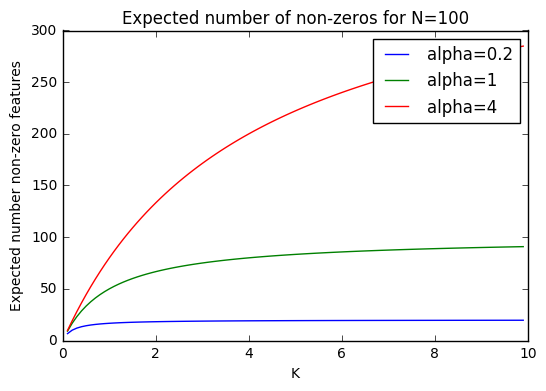

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import math


def plot_nonzeros(alpha, N=100):
    K_values = np.arange(0.1, 10, 0.1)
    nonzero_values = N * alpha / ( 1 + alpha / K_values)
    plt.plot(K_values, nonzero_values, label='alpha=%s' % alpha)

plt.clf()
plot_nonzeros(alpha=0.2)
plot_nonzeros(alpha=1)
plot_nonzeros(alpha=4)
plt.xlabel('K')
plt.ylabel('Expected number non-zero features')
plt.legend()
plt.title('Expected number of non-zeros for N=100')
plt.show()


For all values of $\alpha$, the expected number of non-zeros increases with $K$, reaching an effective plateau at some point.  For smaller values of $\alpha$, the plateau is reached sooner, and is numerically smaller, than for larger values of $\alpha$.

## Equivalence classes

This section assumes one has already read the section in the Griffiths and Ghahramani tutorial on equivalence classes.

Thinking from the start, the equivalence classes will be used in the presence of some data that we will use to calculate the posterior of our prior from.  So, the data will:

- have points in a certain order.  we cant just swap pairs of data points (cf generation, where there is no particular order in which we need to generate new data)
- have points that are probably associated with features, which we could label, eg 'dahl', 'naan'
- however the index numbers of the features can be freely swapped around

So, for example the following two matrixes would be equivalent under these constraints:

```
Feature  1 (dahl)   2           3 (naan)   
Tom      1          0           1          0  ... 0 ...
Jane     0          0           1          0  ... 0 ...
```

```
Feature  345 (naan) 100 (dahl)  222        
Tom      1          1           0          0  ... 0 ...
Jane     1          0           0          0  ... 0 ...
```
...since both matrices show each person eating the same food as in the other matrix, just the feature ids have been swapped around.

If we assumed that each feature column was unique, like:

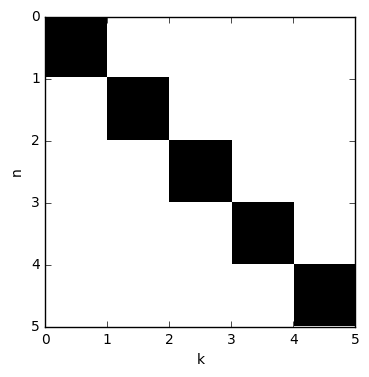

In [50]:
import matplotlib.pyplot as plt
import numpy as np


N = 5
K = 5

grid = np.zeros((N, K, 3), dtype=np.float32)
grid.fill(1.0)
for n in range(N):
    grid[n][n][:] = 0.0

plt.imshow(grid, interpolation='nearest', extent=[0, K, N, 0])
plt.xlabel('k')
plt.ylabel('n')
plt.show()

Or, using just 3 features, and writing out as binary, like eg:

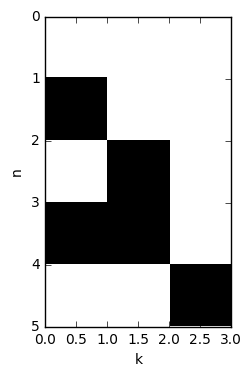

In [59]:
import matplotlib.pyplot as plt
import numpy as np


N = 5
K = 3

grid = np.zeros((N, K, 3), dtype=np.float32)
grid.fill(1.0)
for n in range(N):
    n_bin_str = np.binary_repr(n, width=K)
    for k, v in enumerate(n_bin_str):
        if v == '1':
            grid[n][K - 1 - k][:] = 0.0

plt.imshow(grid, interpolation='nearest', extent=[0, K, N, 0])
plt.xlabel('k')
plt.ylabel('n')
plt.show()

... then if we know how many columns have non-zero values, ie how many features have non-zero values, then the number of ways of arranging these columns, by reordering the index numbers, would be:

$$\mathrm{cardinality\,of\,} \left[ \mathbf{Z} \right]=\, ^{K}P_{\mathrm{number\, non-zero \,features}}$$

If we define 'number features with non-zero values' to be $K^+$, then we can write:

$$\mathrm{cardinality\,of\,} \left[ \mathbf{Z} \right]=\, \frac{K!}{(K - K^+)!}$$

In a sense this is kicking the can down the line, since we don't have a formulae for $K^+$.  But if we imagine a scenario where we are using Gibbs sampling, it seems plausible to imagine that we can easily calculate $K^+$, whereas we wouldnt want to actually count $\frac{K!}{K^+!}$ by hand?

However, in the above, we assume that each of the columns of the matrix is unique.  So we might have a matrix like:

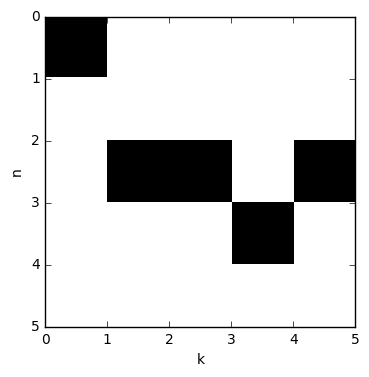

In [61]:
import matplotlib.pyplot as plt
import numpy as np


N = 5
K = 5

grid = np.zeros((N, K, 3), dtype=np.float32)

def grid_plot(grid, x, y):
    grid[y][x][:] = 0.0

grid.fill(1.0)
grid_plot(grid, 0, 0)
grid_plot(grid, 1, 2)
grid_plot(grid, 2, 2)
grid_plot(grid, 3, 3)
grid_plot(grid, 4, 2)

plt.imshow(grid, interpolation='nearest', extent=[0, K, N, 0])
plt.xlabel('k')
plt.ylabel('n')
plt.show()

In this \case, the number of ways of arranging the matrix columns, as calculated by $^KP_{K^+}$, is an over-estimation, because permutating columns 1, 2, and 4 does not create a new matrix.  So, we should compensate, in this case, by dividing by $3!$, ie the number of columns that are identical to each other.

More generally, for any pattern of 1s and 0s in a feature column, we need to count the total number of columns with the exact same pattern, $K_h$, and divide the number of equivalent classes so far by $K_h!$.

In the tutorial, an identifier is defined and created for each pattern of 1s and 0s in a feature column, which is termed the "full history".  The full history is defined to be the integer created by concatenating the 1s and 0s in a feature column into a binary number.  I think the definition is somewhat arbitrary, as long as it uniquely identifies the patterns of 1s and 0s in a feature column, and can be used to concisely and repeatably label such a pattern.

Then, if we know the number of columns of each pattern, $K_h$, for different values of $h$, then the number of equivalence pairs will be:

$$
\mathrm{cardinality\,of\,} \left[ \mathbf{Z} \right]=\,
\frac
  {K!}
  {\prod_{h=0}^{2^N-1}K_h!}
$$

In this notation, we can see a key advantage of using the binary representation is that we can concisely represent all possible feature layouts, by iterating over all binary numbers, from $0$, up to $2^N - 1$.

Thinking about how we'd use this, presumably, in a Gibbs sampling scenario, we could relatively easily obtain the values of $K_h$.  We might not iterate over all the values of $h$ as such: we might just store the counts in a hash table perhaps?  For example, if we had only 1000 data samples, a tiny dataset, then $2^N$ is about $1e300$, which is far beyond the limits of current computers. As a hash table, we'd only need 1000 values, which will be ok.

## Taking the infinite limit

We have:

$$
P(\mathbf{Z} \mid \alpha) =
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^K
\frac
  {\Gamma(m_k + \alpha/K)\Gamma(N-m_k+1}
  {\Gamma(N + \alpha/K + 1)}
$$

and:

$$
\mathrm{cardinality\,of\,} \left[ \mathbf{Z} \right]=\,
\frac
  {K!}
  {\prod_{h=0}^{2^N-1}K_h!}
$$

So:

$$
P([\mathbf{Z}] \mid \alpha) =
\frac
  {K!}
  {\prod_{h=0}^{2^N-1}K_h!}
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^K
\frac
  {\Gamma(m_k + \alpha/K)\Gamma(N-m_k+1}
  {\Gamma(N + \alpha/K + 1)}
$$

We want to find the limit as $K \to \infty$.  Per the tutorial, we should divide the columns of $\mathbf{Z}$ into two sets: those with $m_k = 0$, and those with $m_k > 0$.  We will reorder the features so that $m_k >0 $ iff $k \le K^+$, and $m_k = 0$ otherwise.

So we get:

$$
P([\mathbf{Z}] \mid \alpha) =
\frac
  {K!}
  {\prod_{h=0}^{2^N-1}K_h!}
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^{K^+}
\left(
\frac
  {\Gamma(m_k + \alpha/K)\Gamma(N-m_k+1}
  {\Gamma(N + \alpha/K + 1)}
  \right)
\prod_{k=K^+ + 1}^K
\left(
\frac
  {\Gamma(\alpha/K)\Gamma(N+1}
  {\Gamma(N + \alpha/K + 1)}
  \right)
$$

$$
 =
\frac
  {K!}
  {\prod_{h=0}^{2^N-1}K_h!}
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^{K^+}
\left(
\frac
  {\Gamma(m_k + \alpha/K)\Gamma(N-m_k+1}
  {\Gamma(N + \alpha/K + 1)}
  \right)
\left(
\frac
  {\Gamma(\alpha/K)\Gamma(N+1}
  {\Gamma(N + \alpha/K + 1)}
  \right)^{K_0}
$$

Looking at the limit as $K \to \infty$, any terms like $a + b/K$, where $a$ and $b$ are finite, will tend to $a$.  We need to pay attention to any terms that are just in $aK$, or $a/K$ which will tend to $0$ or $\infty$, respectively.  Gotcha, that got me: $\Gamma(0)$ is not $1$: it's $+\infty$:

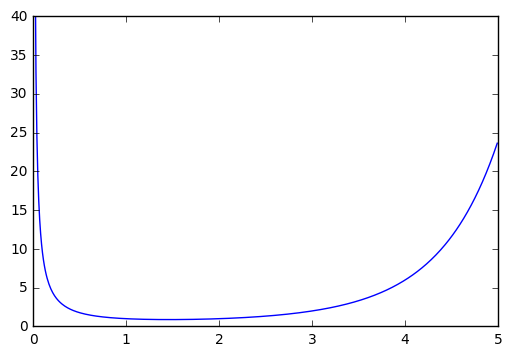

In [72]:
from scipy.special import gamma
import matplotlib.pyplot as plt
import numpy as np


def plot_gamma():
    X = np.arange(0, 5, 0.01)
    y = gamma(X)
    plt.plot(X, y)
    plt.ylim(0, 40)
    plt.show()
plot_gamma()

... so we should expand the term in $\Gamma(\alpha/K)$, on the right hand side:

$$
\to_{K \to \infty}
\frac
  {K!}
  {\prod_{h=0}^{2^N-1}K_h!}
\left(\frac{\alpha}{K}\right)^K
\prod_{k=1}^{K^+}
\left(
\frac
  {\Gamma(m_k)\Gamma(N-m_k+1}
  {\Gamma(N + 1)}
  \right)
\left(
\frac
  {\Gamma(\alpha/K+1) \Gamma(N+1)}
  {(\alpha/K)\Gamma(N + 1)}
  \right)^{K_0}
$$

And we have:
$$
\left(\frac{\alpha}{K} \right)^K \left( \frac{K}{\alpha} \right)^{K_0}
  \to 1
$$
$$\frac{\Gamma(N+1)}{\Gamma(N+1)} = 1$$
$$\Gamma(\alpha/K+1) \to 1$$

So we have:

$$
\to_{K \to \infty}
\frac
  {K!}
  {\prod_{h=0}^{2^N-1}K_h!}
\prod_{k=1}^{K^+}
\left(
\frac
  {\Gamma(m_k)\Gamma(N-m_k+1}
  {\Gamma(N + 1)}
  \right)
$$

Looking at the term on the left, the sum of $K_h$, where $h > 0$, should be $K^+$.  Similarly, $K^+ + K^0 = K$.  Also, for $h> 0$, $K_h \le K^+$. And $\sum_{h=0}^{2^N-1}I[K_h > 0] \le K^+$, where $I[K_h>0]$ is an indicator variable having value $1$ when $K_h > 0$.  But (and I had to check the tutorial to find this), $K_0$ is special, because $K_0 \to \infty$ as $K \to \infty$, and $K_0/K \to 1$ as $K \to \infty$.  So, we should split out $K_0$ from the other $K_h$ in the left hand expression:

$$
\to_{K \to \infty}
\frac
  {K!}
  {K_0!\prod_{h=1}^{2^N-1}K_h!}
\prod_{k=1}^{K^+}
\left(
\frac
  {\Gamma(m_k)\Gamma(N-m_k+1}
  {\Gamma(N + 1)}
  \right)
$$
